In [1]:
# Code from: https://www.linkedin.com/pulse/explain-quantile-mapping-bias-correction-python-code-chonghua-yin/
import numpy as np
from scipy.stats import percentileofscore

def eQM_replace(ref_dataset, model_present, model_future):
    """
    For each model_future value, get its percentile on the CDF of model_present,
    then ust it to get a value from the model_present.
    returns: downscaled model_present and model_future        
    """
    model_present_corrected = np.zeros(model_present.size)  
    model_future_corrected = np.zeros(model_future.size)

    for ival, model_value in enumerate(model_present):
        percentile = percentileofscore(model_present, model_value)
        model_present_corrected[ival] = np.percentile(ref_dataset, percentile)

    for ival, model_value in enumerate(model_future):
        percentile = percentileofscore(model_present, model_value)
        model_future_corrected[ival] = np.percentile(ref_dataset, percentile)
        
    return model_present_corrected, model_future_corrected

def eQM_delta(ref_dataset, model_present, model_future):
    """
    Remove the biases for each quantile value taking the difference between 
    ref_dataset and model_present at each percentile as a kind of systematic bias (delta)
    and add them to model_future at the same percentile.

    returns: downscaled model_present and model_future        
    """

    model_present_corrected = np.zeros(model_present.size)  
    model_future_corrected = np.zeros(model_future.size)

    for ival, model_value in enumerate(model_present):
        percentile = percentileofscore(model_present, model_value)
        model_present_corrected[ival] = np.percentile(ref_dataset, percentile)

    for ival, model_value in enumerate(model_future):
        percentile = percentileofscore(model_future, model_value)
        model_future_corrected[ival] = model_value + np.percentile(
            ref_dataset, percentile) - np.percentile(model_present, percentile)

    return model_present_corrected, model_future_corrected


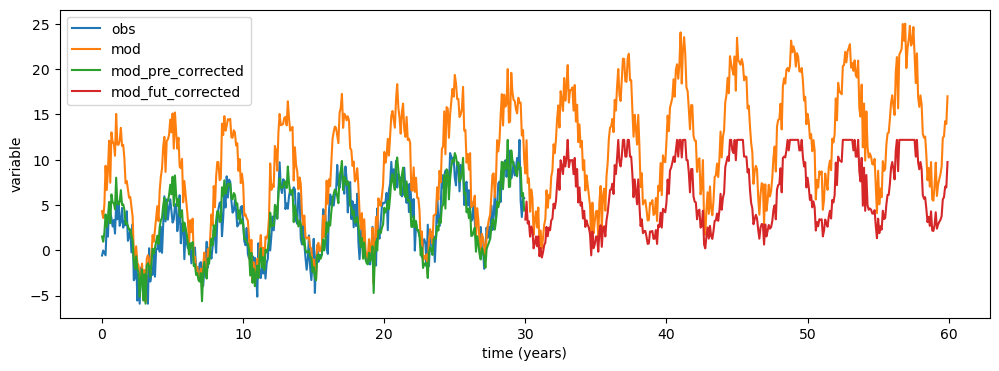

(array([0.03055556, 0.10833333, 0.26111111, 0.39444444, 0.49444444,
        0.56666667, 0.60555556, 0.68611111, 0.81666667, 1.        ]),
 array([-0.80096203,  0.49881652,  1.79859507,  3.09837363,  4.39815218,
         5.69793073,  6.99770928,  8.29748783,  9.59726638, 10.89704493,
        12.19682348]),
 [<matplotlib.patches.Polygon at 0x7f2304dba7c0>])

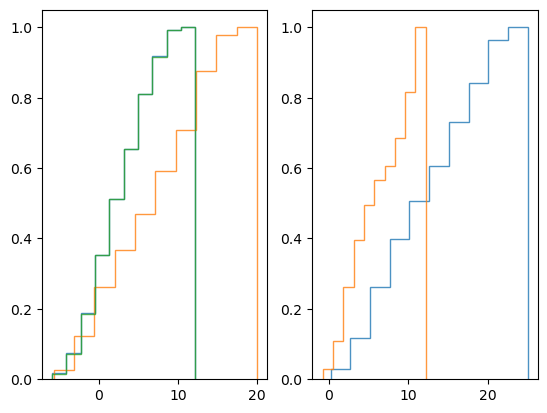

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def generate_data(freq, amplitude, sampling_rate, duration):
    """Generates sinusoidal data."""

    t = np.arange(0, duration, 1/sampling_rate)
    signal = 1/5.*t + amplitude * np.sin(2 * np.pi * freq * t) + np.random.normal(0,1.5,len(t))
    return t, signal

# Parameters
frequency = 0.25  # /yr
amplitude = 4
sampling_rate = 12  # /yr
duration = 30  # years

# Generate the data
t_obs, obs = generate_data(frequency,   amplitude, sampling_rate,   duration)
t_mod, mod = generate_data(frequency, 2*amplitude, sampling_rate, 2*duration)
mod = mod + 4

mod_pre_corrected, mod_fut_corrected = eQM_replace(obs, mod[:len(t_obs)], mod[len(t_obs):])

# Plot the time series
fig = plt.figure(figsize=(12,4))
plt.plot(t_obs, obs)
plt.plot(t_mod, mod)
plt.plot(t_mod[:len(t_obs)], mod_pre_corrected)
plt.plot(t_mod[len(t_obs):], mod_fut_corrected)
plt.xlabel('time (years)')
plt.ylabel('variable')
plt.legend(('obs','mod','mod_pre_corrected','mod_fut_corrected'))
plt.show()

# Plot the CDFs
fig, ax = plt.subplots(1,2)
ax[0].hist(obs, density=True, cumulative=True, label='CDF', histtype='step', alpha=0.8)
ax[0].hist(mod[:len(t_obs)], density=True, cumulative=True, label='CDF', histtype='step', alpha=0.8)
ax[0].hist(mod_pre_corrected, density=True, cumulative=True, label='CDF', histtype='step', alpha=0.8)
ax[1].hist(mod[len(t_obs):], density=True, cumulative=True, label='CDF', histtype='step', alpha=0.8)
ax[1].hist(mod_fut_corrected, density=True, cumulative=True, label='CDF', histtype='step', alpha=0.8)
